In [1]:
%matplotlib inline
import os
import re
import sys
import numpy
import matplotlib.pyplot as plt
try:
   import cPickle as pickle
except:
   import pickle
import matplotlib.patheffects as PathEffects

from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

sys.path.append('/Users/mpagani/Projects/hmtk/')
sys.path.append('/Users/mpagani/Projects/original/oq-engine/')

from hmtk.subduction.cross_sections import CrossSection, Trench
from hmtk.seismicity.selector import CatalogueSelector
from mpl_toolkits.basemap import Basemap

# Resources
* http://nicoya.eas.gatech.edu/Data_Products
* GTDEF http://geophysics.eas.gatech.edu/anewman/classes/MGM/GTdef/

## Load trench data

In [2]:
fin = open('./../data/trench.xy', 'r')
trench = []
for line in fin: 
    aa = re.split('\s+', re.sub('^\s+', '', line))
    trench.append((float(aa[0]), float(aa[1])))
fin.close()
trench = Trench(numpy.array(trench))

In [3]:
cat = pickle.load(open("./../data/catalogue_ext_cac.p", "rb" ))

## Compute the traces of cross-sections

In [4]:
minlo = -110
minla = 5
maxlo = -75
maxla = 25
midlo = -100
midla = 20

In [5]:
from hmtk.parsers.catalogue.gcmt_ndk_parser import ParseNDKtoGCMT
from obspy.imaging.beachball import beach

gcmt_filename = '/Users/mpagani/Data/catalogues/gcmt/jan76_dec13.ndk'
gcmtc = ParseNDKtoGCMT(gcmt_filename)
gcmtc.read_file()

def plot_nodal_planes(catalogue, ax, minlo, minla, maxlo, maxla):    
    beach1 = beach(np1, xy=(-70, 80), width=30)
    beach2 = beach(mt, xy=(50, 50), width=50)
    ax.add_collection(beach1) 
    ax.add_collection(beach2)

Parsing catalogue ...
complete. Contains 40514 moment tensors


depths: 0.000000 620.000000 
-106.479700 21.250800 400.000000 89.098531 0
-106.465026 20.376531 400.000000 67.066769 1
-106.104304 19.572835 400.000000 41.776316 2
-105.407799 18.983108 400.000000 42.780416 3
-104.708853 18.367960 400.000000 33.326921 4
-103.930950 17.879579 400.000000 25.746770 5
-103.028321 17.462258 400.000000 27.972495 6
-102.221598 17.051027 400.000000 19.299185 7
-101.366112 16.762399 400.000000 20.070106 8
-100.514850 16.462395 400.000000 20.423195 9
-99.572712 16.123286 400.000000 22.346540 10
-98.697211 15.775165 400.000000 17.168449 11
-97.877703 15.529695 400.000000 16.664268 12
-96.948511 15.259426 400.000000 358.956017 13
-95.971619 15.274484 400.000000 24.334244 14
-95.213657 14.942028 400.000000 34.880021 15
-94.398783 14.390371 400.000000 28.887802 16
-93.621998 13.973200 400.000000 28.434593 17
-92.834346 13.557326 400.000000 26.986459 18
-91.956233 13.120316 400.000000 26.187656 19
-91.141263 12.728095 400.000000 23.241966 20


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


-90.305472 12.376189 400.000000 18.409296 21
-89.435796 12.091779 400.000000 21.734211 22
-88.618237 11.771534 400.000000 28.757504 23
-87.802814 11.331612 400.000000 40.695552 24
-87.191426 10.814529 400.000000 51.774751 25
-86.558068 10.022019 400.000000 45.500281 26
-85.982854 9.444109 400.000000 30.037732 27
-85.102747 8.940306 400.000000 26.254909 28
-84.360153 8.577385 400.000000 31.195920 29
-83.577886 8.107659 400.000000 38.349301 30
-82.875922 7.556527 400.000000 36.664884 31


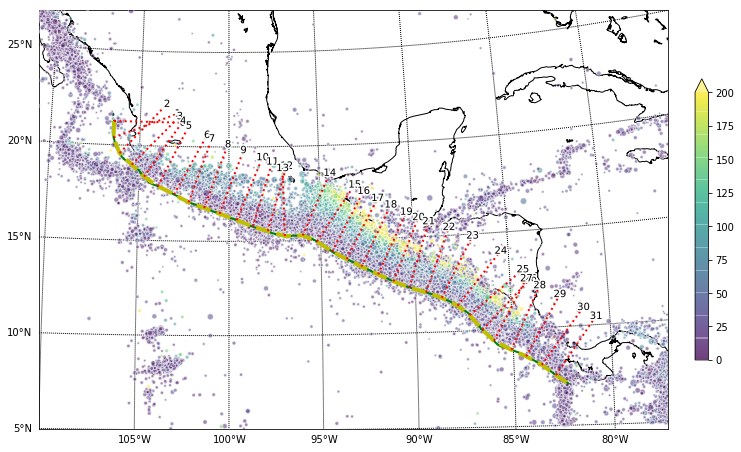

In [8]:
fig = plt.figure(figsize=(12,9))

#
# Plot the basemap
m = Basemap(llcrnrlon=minlo, llcrnrlat=minla,
            urcrnrlon=maxlo, urcrnrlat=maxla,
            resolution='i', projection='tmerc', 
            lon_0=midlo, lat_0=midla)

#
# Draw paralleles and meridians with labels 
# labels = [left,right,top,bottom]
m.drawcoastlines()
m.drawmeridians(numpy.arange(numpy.floor(minlo/10.)*10,
                             numpy.ceil(maxlo/10.)*10,5.),
               labels=[False, False, False, True])
m.drawparallels(numpy.arange(numpy.floor(minla/10.)*10,
                             numpy.ceil(maxla/10.)*10,5.),
               labels=[True, False, False, False])

#
# Plot the instrumental catalogue
xa, ya = m(cat.data['longitude'], cat.data['latitude'])
szea = (cat.data['magnitude']*100)**1.5
patches = []
for x, y, sze in zip(list(xa), list(ya), szea):
    circle = Circle((x, y), sze, ec='white')
    patches.append(circle)
print ('depths: %f %f ' % (min(cat.data['depth']), max(cat.data['depth'])))
colors = cat.data['depth']
p = PatchCollection(patches, zorder=6, edgecolors='white')
p.set_alpha(0.5)
p.set_clim([0, 200])
p.set_array(numpy.array(colors))
plt.gca().add_collection(p)
plt.colorbar(p,fraction=0.02, pad=0.04, extend='max')

#
# GCMT 
x, y = m(gcmtc.catalogue.data['longitude'], 
         gcmtc.catalogue.data['latitude'])
#plt.plot(x, y, 'sr', zorder=10, alpha=.5)

#
# Plot the traces of cross-sections
distance = 100
cs_len = 400

ts = trench.resample(distance)

fou = open('cs_traces.csv', 'w')
x, y = m(trench.axis[:, 0], trench.axis[:, 1])
plt.plot(x, y, '-g', linewidth=2, zorder=10)
x, y = m(ts.axis[:, 0], ts.axis[:, 1])
plt.plot(x, y, '--y', linewidth=4, zorder=20)

for idx, cs in enumerate(trench.iterate_cross_sections(distance, cs_len)):
    if cs is not None:
        x, y = m(cs.plo, cs.pla)
        plt.plot(x, y, ':r', linewidth=2, zorder=20)
        text = plt.text(x[-1], y[-1], '%d' % idx, ha='center', va='center', size=10, zorder=30)
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="w")])
        tmps = '%f %f %f %f %d\n' % (cs.plo[0], cs.pla[0], cs_len, cs.strike[0], idx)
        print (tmps.rstrip())
        fou.write(tmps)
fou.close()